# Sliding Window Functional Connectivity Analysis

The following notebook contains the formal analysis procedure for the computing of dynamic functional connectivity using a sliding window approach. 

# `conda`

A conda environment has been created just for this analysis

In [ ]:
!conda activate swfc

# Get list of data

This was generated [here](../EventSeg/main.ipynb).

In [2]:
import pandas as pd
out = "/data/jdecke5/projects/honors-thesis/data"
df = pd.read_csv(f'{out}/pps.csv')
data = list(df["files"])
data

['/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL001/func/sub-SL001_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL002/func/sub-SL002_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL003/func/sub-SL003_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL004/func/sub-SL004_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL005/func/sub-SL005_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL006/func/sub-SL006_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projec

# Get a `dict` of subject IDs

In [3]:
from decker.utils.io.io import parse_pdb

In [4]:
db = "/data/jdecke5/projects/honors-thesis/data/participant_database.xlsx"
pps = parse_pdb(path=db, subid_col="Subject ID", cond_col="COND")
pps

{'S': ['SL001',
  'SL003',
  'SL004',
  'SL007',
  'SL009',
  'SL011',
  'SL013',
  'SL015',
  'SL017',
  'SL019'],
 'R': ['SL002',
  'SL005',
  'SL006',
  'SL008',
  'SL010',
  'SL012',
  'SL014',
  'SL016',
  'SL018']}

# Load in masked data
This was generated [here](../EventSeg/main.ipynb).

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

# where?
eventseg_dir = "/data/jdecke5/projects/honors-thesis/data/eventseg"
roidata_masked = np.load(os.path.join(eventseg_dir, "masked_data.npy"), allow_pickle=True)[()]

### Plot

Text(0.5, 0.98, 'Subject SL008')

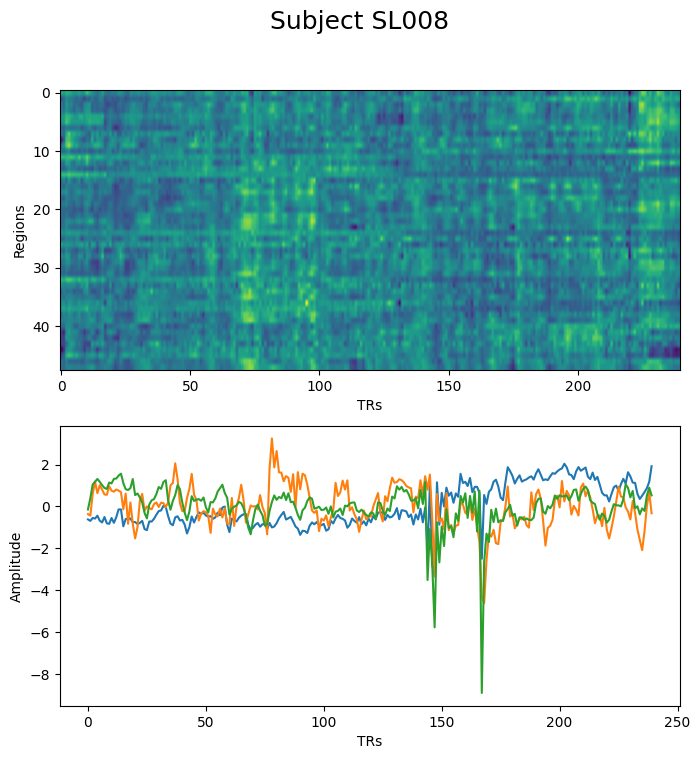

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].imshow(roidata_masked["R"][3].T, aspect='auto')
ax[0].set_xlabel("TRs")
ax[0].set_ylabel("Regions")

[ax[1].plot(roidata_masked["R"][2][:, idx]) for idx in range(3)] # labels come from `nilearn_mask_single_data()`
ax[1].set_xlabel("TRs")
ax[1].set_ylabel("Amplitude")

fig.suptitle(f'Subject {pps["R"][3]}', fontsize=18)

# Testing on a single subject

In [10]:
from pydfc import data_loader
import numpy as np
from pydfc.dfc_methods import SLIDING_WINDOW


Dataset created in /home/jdecke5/nilearn_data/schaefer_2018



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)
/data/jdecke5/.conda/envs/swfc/lib/python3.11/site-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


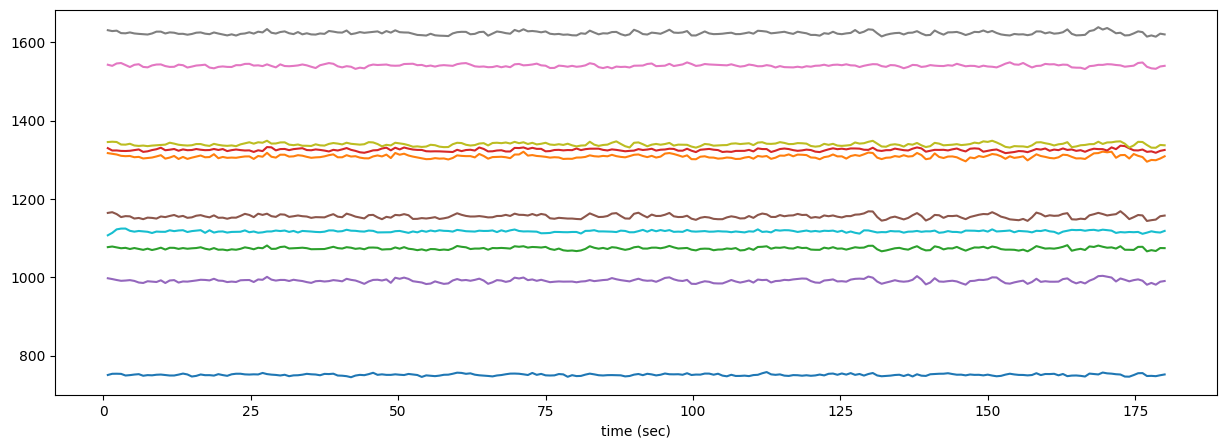

In [8]:
# load sub-0001 data from nifti file
BOLD = data_loader.nifti2timeseries(
    nifti_file=data[0],
    n_rois=48,
    Fs=1 / 0.75,
    subj_id="sub-SL001",
    confound_strategy="no_motion",  # no_motion, no_motion_no_gsr, or none
    standardize=False,
    TS_name=None,
    session=None,
)

BOLD.visualize(start_time=0, end_time=1000, nodes_lst=range(10))

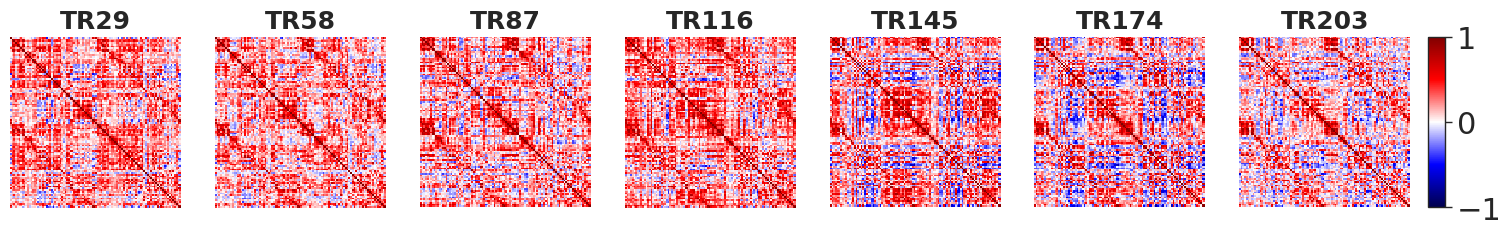

In [11]:
params_methods = {
    # W is window length in sec
    "W": 44,
    "n_overlap": 0.5,
    "sw_method": "pear_corr",
    "tapered_window": True,
    # data Parameters
    "normalization": True,
    "num_select_nodes": None,  # you can make the number of nodes smaller, e.g. by setting to 50, for faster computation
}

measure = SLIDING_WINDOW(**params_methods)
dFC = measure.estimate_dFC(time_series=BOLD)
dFC.visualize_dFC(
    TRs=dFC.TR_array[:], normalize=False, fix_lim=False
)  # TRs are time point indices, e.g. TR=0 is the first time point, TR=1 is the second time point, etc.

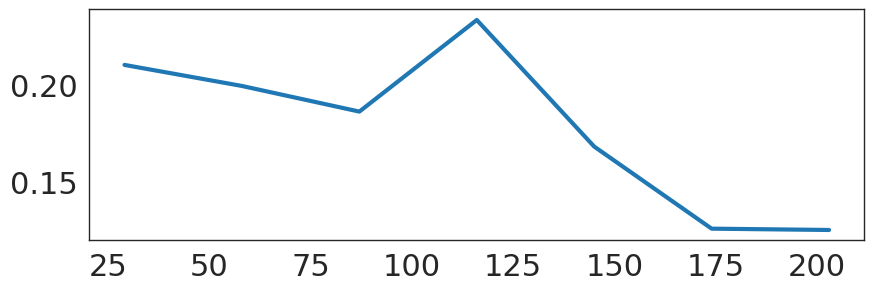

In [12]:
avg_dFC = np.mean(np.mean(dFC.get_dFC_mat(), axis=1), axis=1)
plt.figure(figsize=(10, 3))
plt.plot(dFC.TR_array, avg_dFC)
plt.show()

# Create condition-wise averages

In [19]:
import nibabel as nib

Text(0.5, 1.0, 'Structured group average')

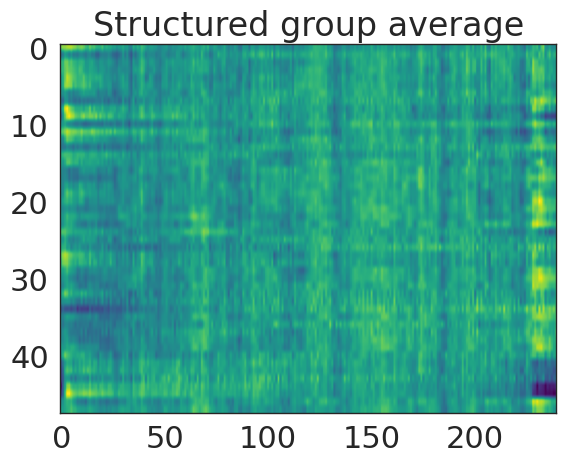

In [15]:
str_data = np.mean(roidata_masked["S"], axis=0)
plt.imshow(str_data.T, cmap='viridis', aspect='auto')
plt.title('Structured group average')

### Save as `.npy` and as `.nii.gz`

In [21]:
np.save(os.path.join(eventseg_dir, 'structured_masked_data.npy'), str_data)
nifti = nib.nifti1.Nifti1Image(str_data, affine=None)
nib.save(nifti, os.path.join(eventseg_dir, 'structured_masked_data.nii.gz'))

# Compute SWFC over grouped data

### Get only structured group for now

In [37]:
subject_ids_s = pps['S']
files_for_s_group = [file_path for file_path in data for subject_id in subject_ids_s if subject_id in file_path]
files_for_s_group

['/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL001/func/sub-SL001_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL003/func/sub-SL003_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL004/func/sub-SL004_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL007/func/sub-SL007_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL009/func/sub-SL009_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL011/func/sub-SL011_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projec

### Aggregate data into requisite structure

In [110]:
BOLD_multi = data_loader.multi_nifti2timeseries(
    files_for_s_group,
    pps["S"],
    n_rois=100,
    Fs=1 / 0.75,
    confound_strategy="no_motion",
    standardize=False,
    TS_name=None,
    session=None,
)

/data/jdecke5/.conda/envs/swfc/lib/python3.11/site-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/data/jdecke5/.conda/envs/swfc/lib/python3.11/site-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/data/jdecke5/.c

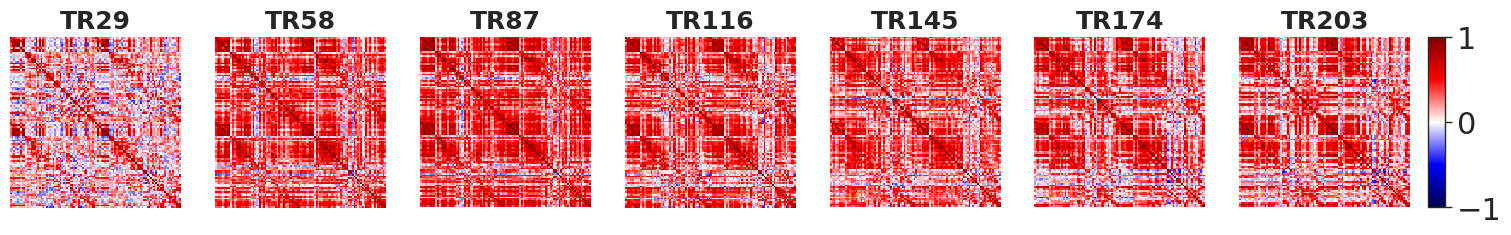

In [140]:
params_methods = {
    # W is window length in sec
    "W": 44,
    "n_overlap": 0.5,
    "sw_method": "pear_corr",
    "tapered_window": True,
    # data Parameters
    "normalization": True,
    "num_select_nodes": None,  # you can make the number of nodes smaller, e.g. by setting to 50, for faster computation
}

measure = SLIDING_WINDOW(**params_methods)
dFC = measure.estimate_dFC(time_series=BOLD_multi.get_subj_ts(subjs_id="SL019"))
dFC.visualize_dFC(
    TRs=dFC.TR_array[:], normalize=False, fix_lim=False
)  # TRs are time point indices, e.g. TR=0 is the first time point, TR=1 is the second time point, etc.

In [141]:
d = dFC.get_dFC_mat()
type(d[0])

numpy.ndarray

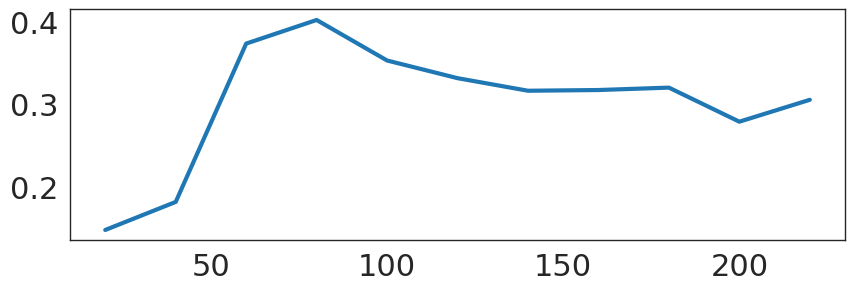

In [139]:
avg_dFC = np.mean(np.mean(dFC.get_dFC_mat(), axis=1), axis=1)
plt.figure(figsize=(10, 3))
plt.plot(dFC.TR_array, avg_dFC)
plt.show()

### Average across all participants

In [142]:
dfc = {}

print("Beginning...")
print(f'------------\n')

for i in pps["S"]:

    # compute SWFC
    measure = SLIDING_WINDOW(**params_methods)
    dFC = measure.estimate_dFC(time_series=BOLD_multi.get_subj_ts(subjs_id=i))

    # output
    print(f'SWFC computed for {i}\n')

    # append subject-wise average
    dfc[i] = dFC.get_dFC_mat()

    print(f'\tAppended to average\n')

print(f'------------\n')
print('Done')

Beginning...
------------



SWFC computed for SL001

	Appended to average

SWFC computed for SL003

	Appended to average

SWFC computed for SL004

	Appended to average

SWFC computed for SL007

	Appended to average

SWFC computed for SL009

	Appended to average

SWFC computed for SL011

	Appended to average

SWFC computed for SL013

	Appended to average

SWFC computed for SL015

	Appended to average

SWFC computed for SL017

	Appended to average

SWFC computed for SL019

	Appended to average

------------

Done


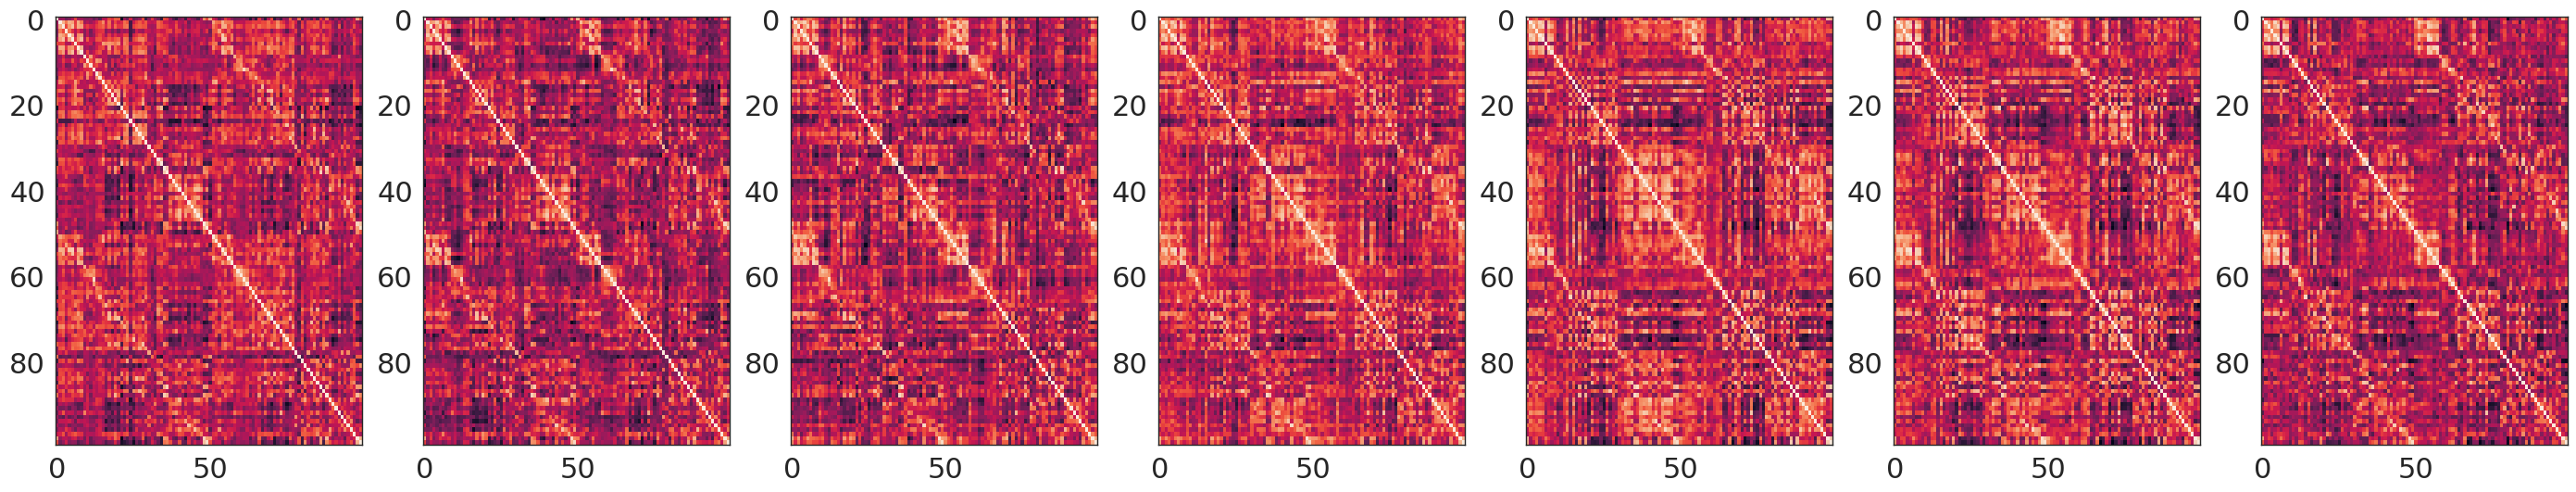

In [150]:
fix, ax = plt.subplots(ncols=7, figsize=(35, 6))
[ax[i].imshow(dfc["SL001"][i], aspect='auto') for i in range(len(dfc["SL001"]))]

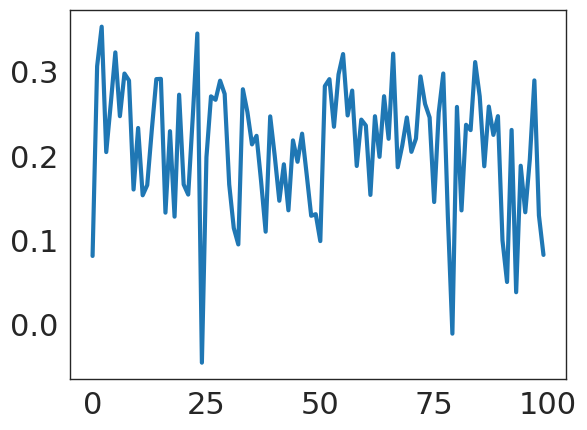

In [158]:
from sklearn.cluster import KMeans
data_mean = np.mean(dfc["SL001"][0], axis=0)
plt.plot(np.arange(0, 100), data_mean)

Average over subjects

### Now do this for random group

In [109]:
subject_ids_r = pps['R']
files_for_r_group = [file_path for file_path in data for subject_id in subject_ids_r if subject_id in file_path]
files_for_r_group

['/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL002/func/sub-SL002_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL005/func/sub-SL005_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL006/func/sub-SL006_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL008/func/sub-SL008_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL010/func/sub-SL010_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL012/func/sub-SL012_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projec

### Aggregate data into requisite structure

In [ ]:
BOLD_multi = data_loader.multi_nifti2timeseries(
    data,
    pps["R"],
    n_rois=100,
    Fs=1 / 0.75,
    confound_strategy="no_motion",
    standardize=False,
    TS_name=None,
    session=None,
)

In [162]:
type(BOLD_multi)

pydfc.time_series.TIME_SERIES

In [163]:
type(dfc)

dict